# Semantic Segmentation using U-Net
Note that it is recommended to load this Notebook in Google Colab to make use of the GPU processors to speed up the training process

## Load packages


In [1]:
import os, random
import numpy as np # linear algebra
from scipy.io import loadmat
import imageio
import cv2
import tensorflow as tf
from tensorflow.keras.utils  import load_img, array_to_img, img_to_array
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras import backend as K
from skimage.color import label2rgb
from skimage.exposure import equalize_adapthist
from tqdm.notebook import tqdm

import matplotlib.pylab as plt
%matplotlib inline


## Plotting functions



In [2]:
# Plotting function
def plot_image_and_label(image,label,values_255=True):
  '''
  Function for plotting images and labels
  '''
  if(not(values_255)):
    image_plot = cv2.normalize(image,None,0,255,cv2.NORM_MINMAX).astype(np.uint8)
  else:
    image_plot = image
  # Adapt label
  labelmap = np.zeros(image.shape)
  for i in range(label.shape[-1]):
    labelmap[label[:,:,i]==1] = i+1
  # Plot
  plt.figure(figsize=(14,8))
  plt.subplot(1,3,1)
  plt.imshow(image_plot, 'gray')
  plt.title("Image")
  plt.subplot(1,3,2)
  plt.imshow(labelmap, 'gray')
  plt.title("Ground truth (GT) mask")
  plt.subplot(1,3,3)
  plt.imshow(label2rgb(label=labelmap, image=image_plot, bg_label=0))
  plt.title("Image + GT Mask")

# Plotting function
def plot_image_and_pred_label(image,pred_label,label,values_255=True):
  '''
  Function for plotting images and labels (predicted and GT)
  '''
  if(not(values_255)):
    image_plot = cv2.normalize(image,None,0,255,cv2.NORM_MINMAX).astype(np.uint8)
  else:
    image_plot = image
  # Adapt label
  pred_labelmap = np.zeros(image.shape)
  labelmap = np.zeros(image.shape)
  for i in range(pred_label.shape[-1]):
    pred_labelmap[pred_label[:,:,i]==1] = i+1
  for i in range(label.shape[-1]):
    labelmap[label[:,:,i]==1] = i+1
  # Plot
  plt.figure(figsize=(16,12))
  plt.subplot(1,5,1)
  plt.imshow(image_plot, 'gray')
  plt.title("Image")
  plt.subplot(1,5,2)
  plt.imshow(pred_labelmap, 'gray')
  plt.title("Predicted mask")
  plt.subplot(1,5,3)
  plt.imshow(labelmap, 'gray')
  plt.title("Ground truth (GT) mask")
  plt.subplot(1,5,4)
  plt.imshow(label2rgb(label=pred_labelmap, image=image_plot, bg_label=0))
  plt.title("Image + Predicted Mask")
  plt.subplot(1,5,5)
  plt.imshow(label2rgb(label=labelmap, image=image_plot, bg_label=0))
  plt.title("Image + GT Mask")

## Load the dataset and split the data


Load the data

In [3]:
data = loadmat('./data/UNet_data.mat')
images, labels = data['images'], data['labels']

Check the shapes of the numpy arrays (input data)

In [4]:
print(images.shape)
print(labels.shape)

(247, 512, 512)
(247, 512, 512, 5)


We have a total of 247 chest X-ray images with a resolution of `512 x 512`. On the other hand, our ground truth segmentations (`labels`) are included in a numpy array of 247 images with a size of 512 x 512 x 5, where 5 corresponds to the number of labelmaps and the number of classes. We have one labelmap per class:
* **First class/labelmap (dim=0):** Left lung
* **Second class/labelmap (dim=1):** Right lung
* **Third class/labelmap (dim=2):** Heart
* **Fourth class/labelmap (dim=3):** Left clavicle
* **Fifth class/labelmap (dim=4):** Right clavicle

**Note**: In chest X-ray images, what we see on the left side corresponds to the right side of the body, and viceversa.

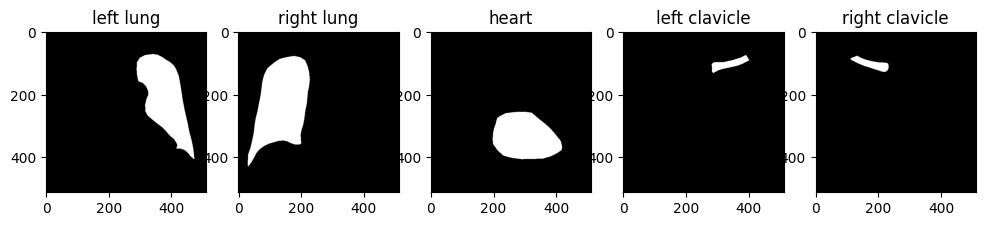

In [5]:
N = 10  # Change this number to visualize another labelmap
plt.figure(figsize=(12,5))
titles = ['left lung', 'right lung', 'heart', 'left clavicle', 'right clavicle']
for i in range(labels.shape[-1]):
  plt.subplot(1,labels.shape[-1],i+1)
  plt.imshow(labels[N,:,:,i], 'gray')
  plt.title(titles[i])

### Show some images and labels from the dataset

Text(0.5, 1.0, 'Mask histogram')

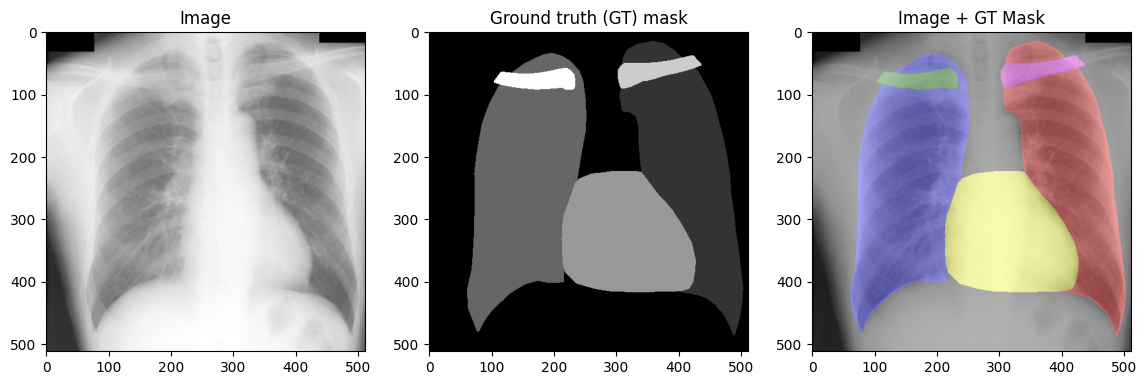

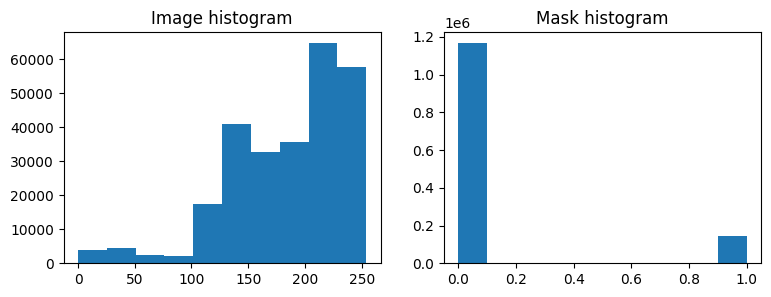

In [33]:
N = 22  # Change this number to visualize another image-mask set
img = images[N]
mask = labels[N]
plot_image_and_label(img,mask)

plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
plt.hist(img.flatten())
plt.title("Image histogram")
plt.subplot(1,2,2)
plt.hist(mask.flatten())
plt.title("Mask histogram")


## Preprocess data

Steps to preprocess the data 
1. Apply contrast limited adaptive histogram equalization (CLAHE) to the images. By applying this equalization, we are able to perform a better segmentation of the different structures present in the image. 
2. Normalize the images to zero-mean and unit variance using the following formula:  $\frac{X-\mu}{\sigma + \epsilon}$

  Where X is the image, $\mu$ is the mean value of the image, $\sigma$ is the standard deviation and $\epsilon$ is a constant that prevents division by zero. This operation allows the network to train more efficiently.


In [7]:
def preprocess_img(img):
  # Get the maximum value of the input image using np.max. 
  max_value = np.max(img)
  # Apply CLAHE to the image. 
  img = equalize_adapthist(img)
  # Normalize the image between 0 and max_value and then assign uint8 (np.uint8) type using CV2.NORM_MINMAX as norm_type.
  img = cv2.normalize(img, None, 0, max_value, cv2.NORM_MINMAX).astype(np.uint8)
  return img

def normalize_img(img, epsilon=1e-10):
  # Normalize the image to zero mean and unit variance. See formula above.
  img_norm = (img - np.mean(img)) / (np.std(img) + epsilon)
  return img_norm

In [ ]:
X = np.zeros(images.shape)
y = labels.astype(np.float32)
for i, (img, lbl) in enumerate(tqdm(zip(images,labels), total=len(images))):
  img_preprocessed = preprocess_img(img) 
  img_norm = normalize_img(img_preprocessed) 
  X[i] = img_norm

  0%|          | 0/247 [00:00<?, ?it/s]

### Show some images and labels from the dataset afer being preprocessed and normalized

Image mean: -2.0816681711721685e-17
Image std: 0.9999999999984533
Labelmap mean: 0.11061401665210724
Labelmap std: 0.31365370750427246


Text(0.5, 1.0, 'Mask histogram')

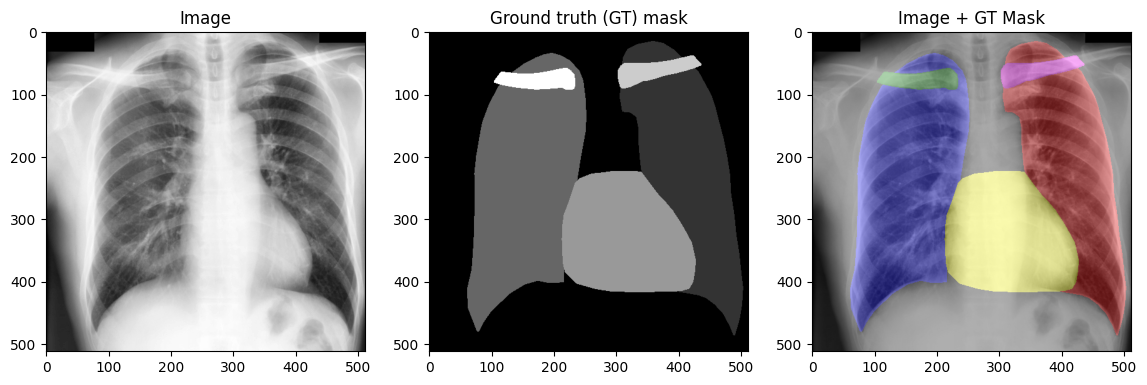

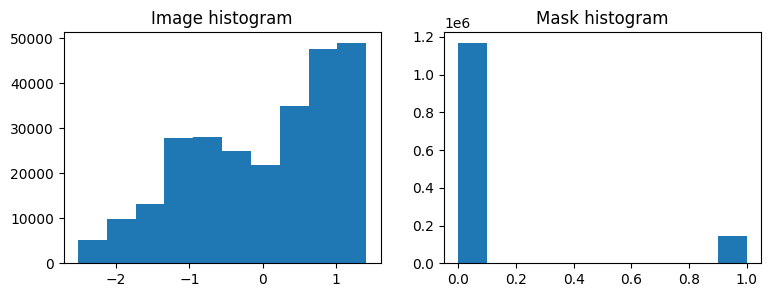

In [34]:
N = 22  # Change this number to open another set of image-mask
plot_image_and_label(X[N],y[N],values_255=False)
print(f"Image mean: {X[N].mean()}")
print(f"Image std: {X[N].std()}")
print(f"Labelmap mean: {y[N].mean()}")
print(f"Labelmap std: {y[N].std()}")
plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
plt.hist(X[N].flatten())
plt.title("Image histogram")
plt.subplot(1,2,2)
plt.hist(y[N].flatten())
plt.title("Mask histogram")

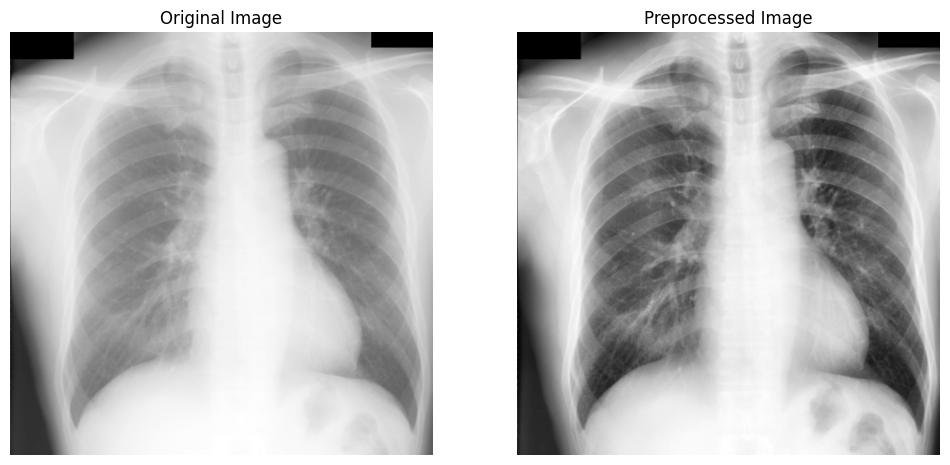

In [37]:
import matplotlib.pyplot as plt

img = images[N]   
preprocessed_img = X[N] 

# Plotting the original image
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img, cmap='gray')
plt.axis('off')

# Plotting the preprocessed image
plt.subplot(1, 2, 2)
plt.title('Preprocessed Image')
plt.imshow(preprocessed_img, cmap='gray')
plt.axis('off')

plt.show()

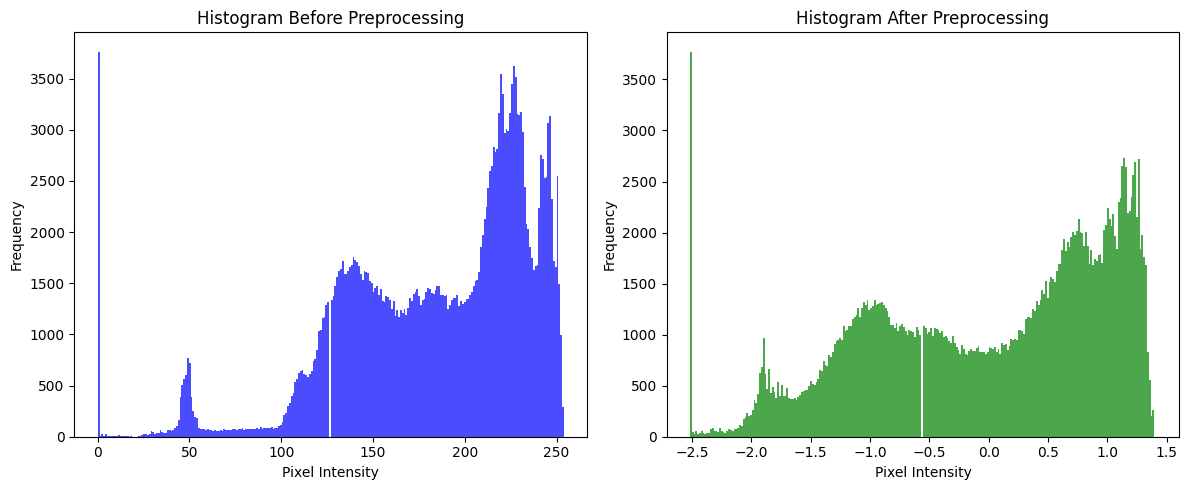

In [35]:
import numpy as np

import matplotlib.pyplot as plt

img = images[N]   
preprocessed_img = X[N] 

# Plotting the histograms
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histogram before preprocessing
axes[0].hist(img.ravel(), bins=256, color='blue', alpha=0.7)
axes[0].set_title('Histogram Before Preprocessing')
axes[0].set_xlabel('Pixel Intensity')
axes[0].set_ylabel('Frequency')

# Histogram after preprocessing
axes[1].hist(preprocessed_img.ravel(), bins=256, color='green', alpha=0.7)
axes[1].set_title('Histogram After Preprocessing')
axes[1].set_xlabel('Pixel Intensity')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### Split the data into training and testing sets 


In [10]:
from sklearn.model_selection import train_test_split
# Implement the code needed to split the data as detailed above (approx. 1 line)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

Check now how many data we have in each array obtained from the split

In [11]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(197, 512, 512)
(197, 512, 512, 5)
(50, 512, 512)
(50, 512, 512, 5)


### Show some images and labels from the training dataset

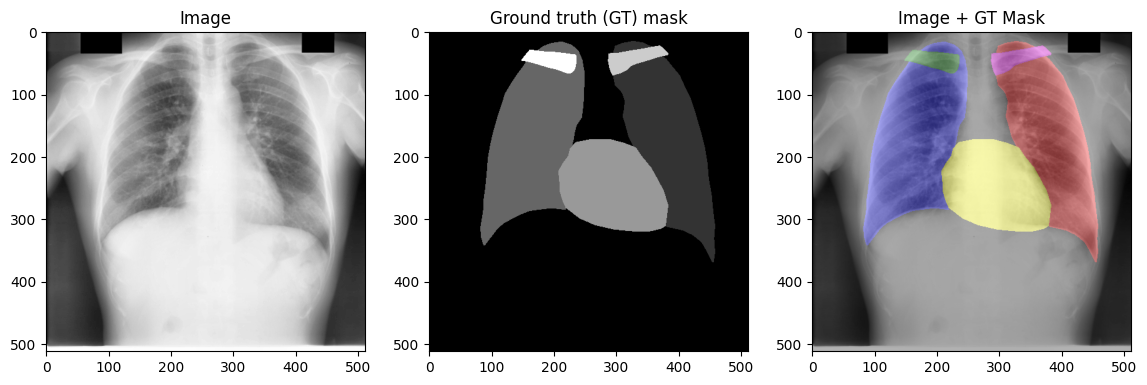

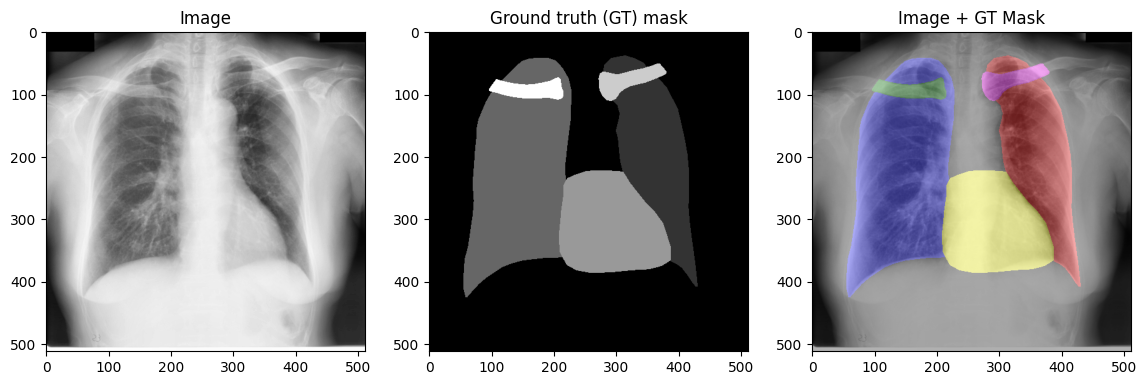

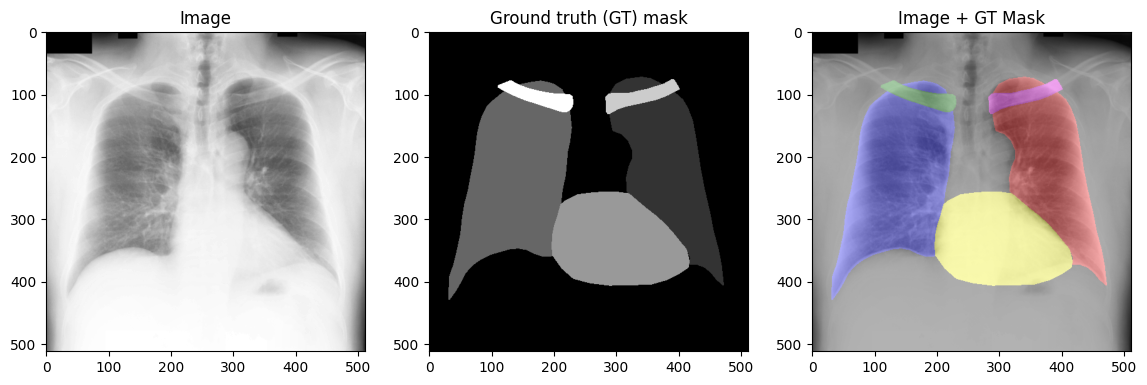

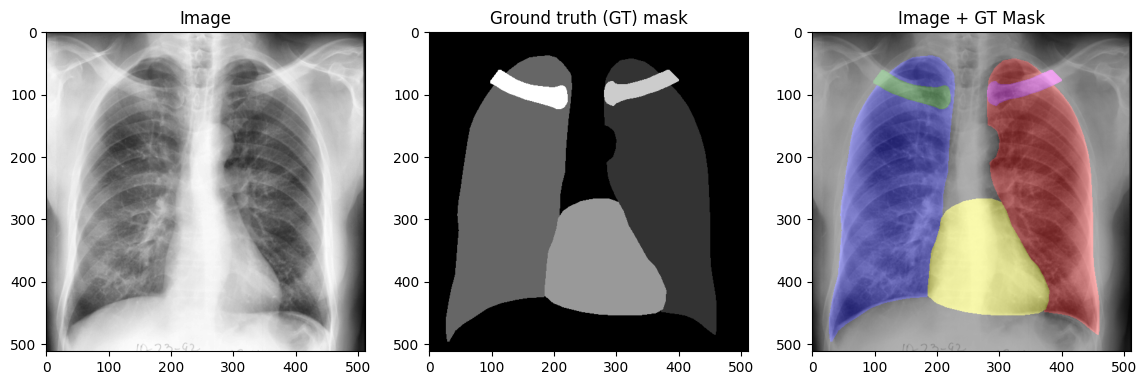

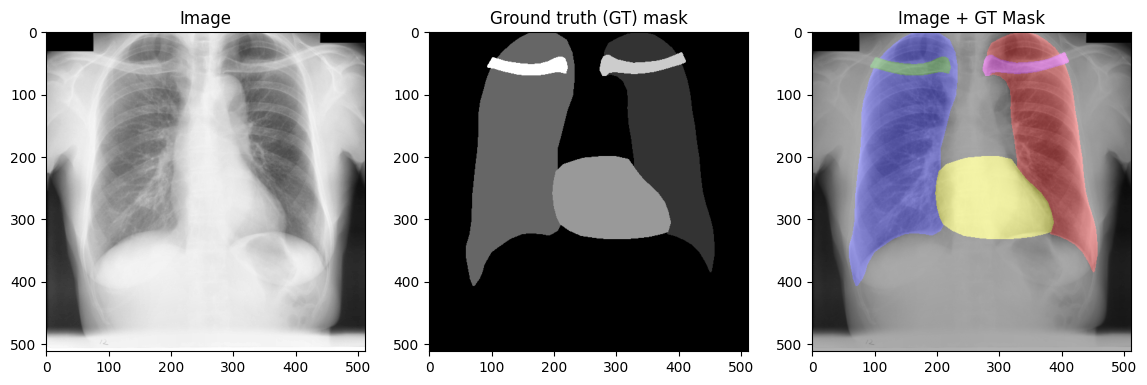

In [12]:
# Sanity check: show some images and mask from the training data
indx = np.random.randint(0, len(X_train), 5)

for i in indx:
  plot_image_and_label(X_train[i], y_train[i], values_255=False)

## Build the U-Net model

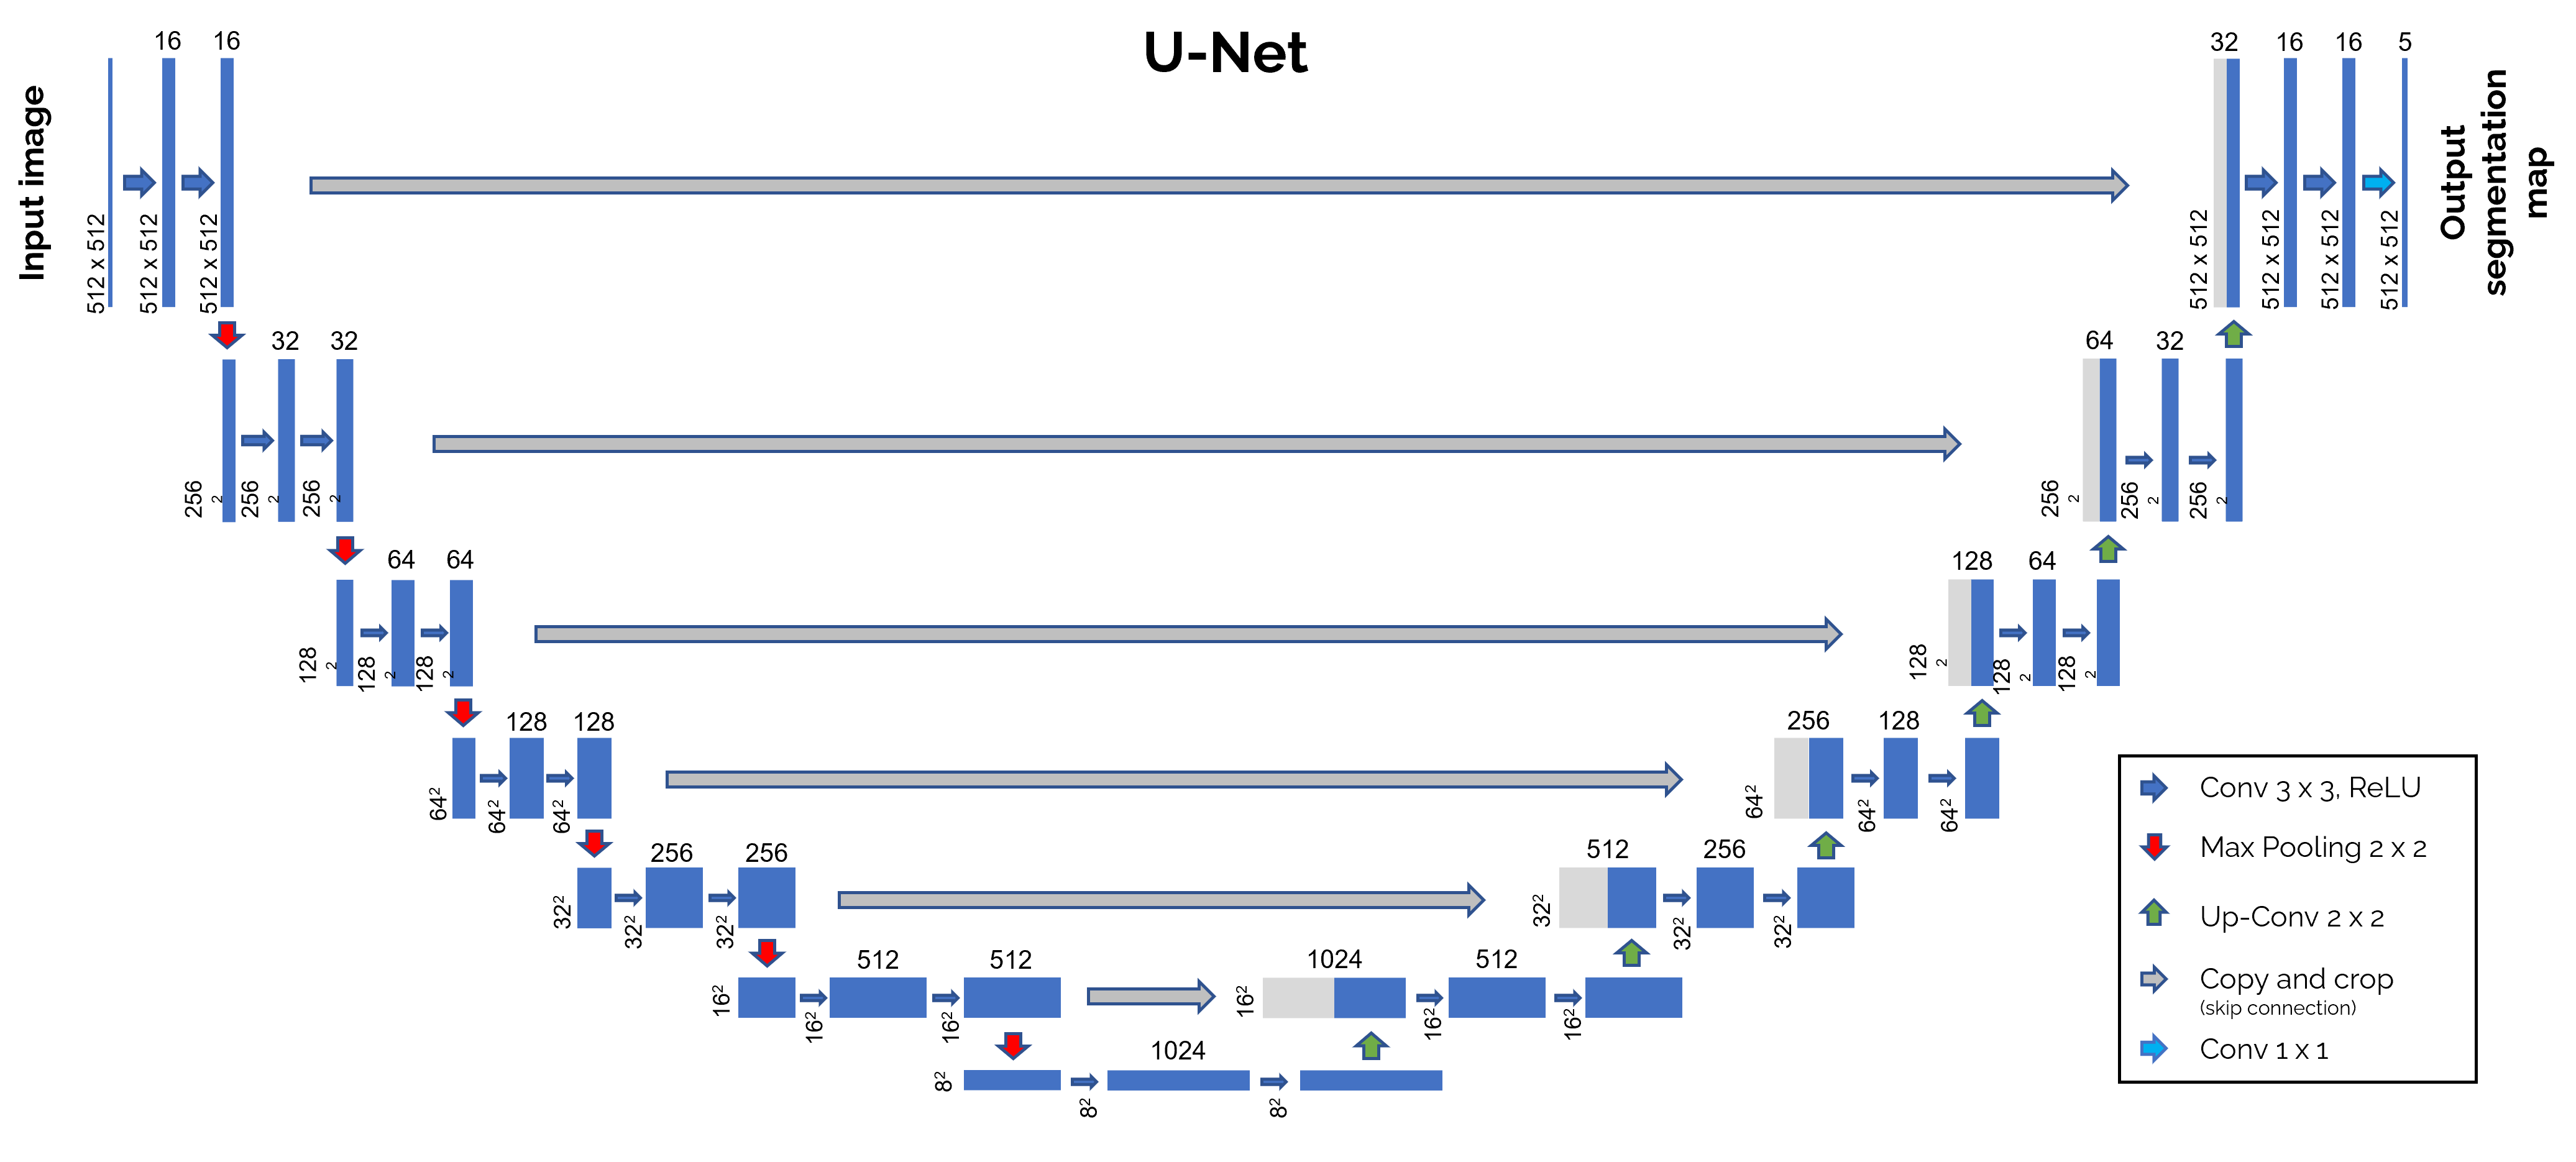

Once we have verified that all our images and labels are correctly preprocessed, split and adapted, we are going to build our **U-Net** segmentation model. The U-Net model is composed of two main branches: an encoder and a decoder. The **encoder** is the block that downsamples the image, encoding the information into a smaller tensor, and the **decoder** decodes this information by upsampling the tensors into a larger image.


### Define the input to the U-Net

In [13]:
# Define the input image size (width, height, channels) and the number of classes
img_w, img_h = images.shape[1], images.shape[2]
img_c = 1
mask_c = labels.shape[3]

### Build the Encoder (Downsampling Block)

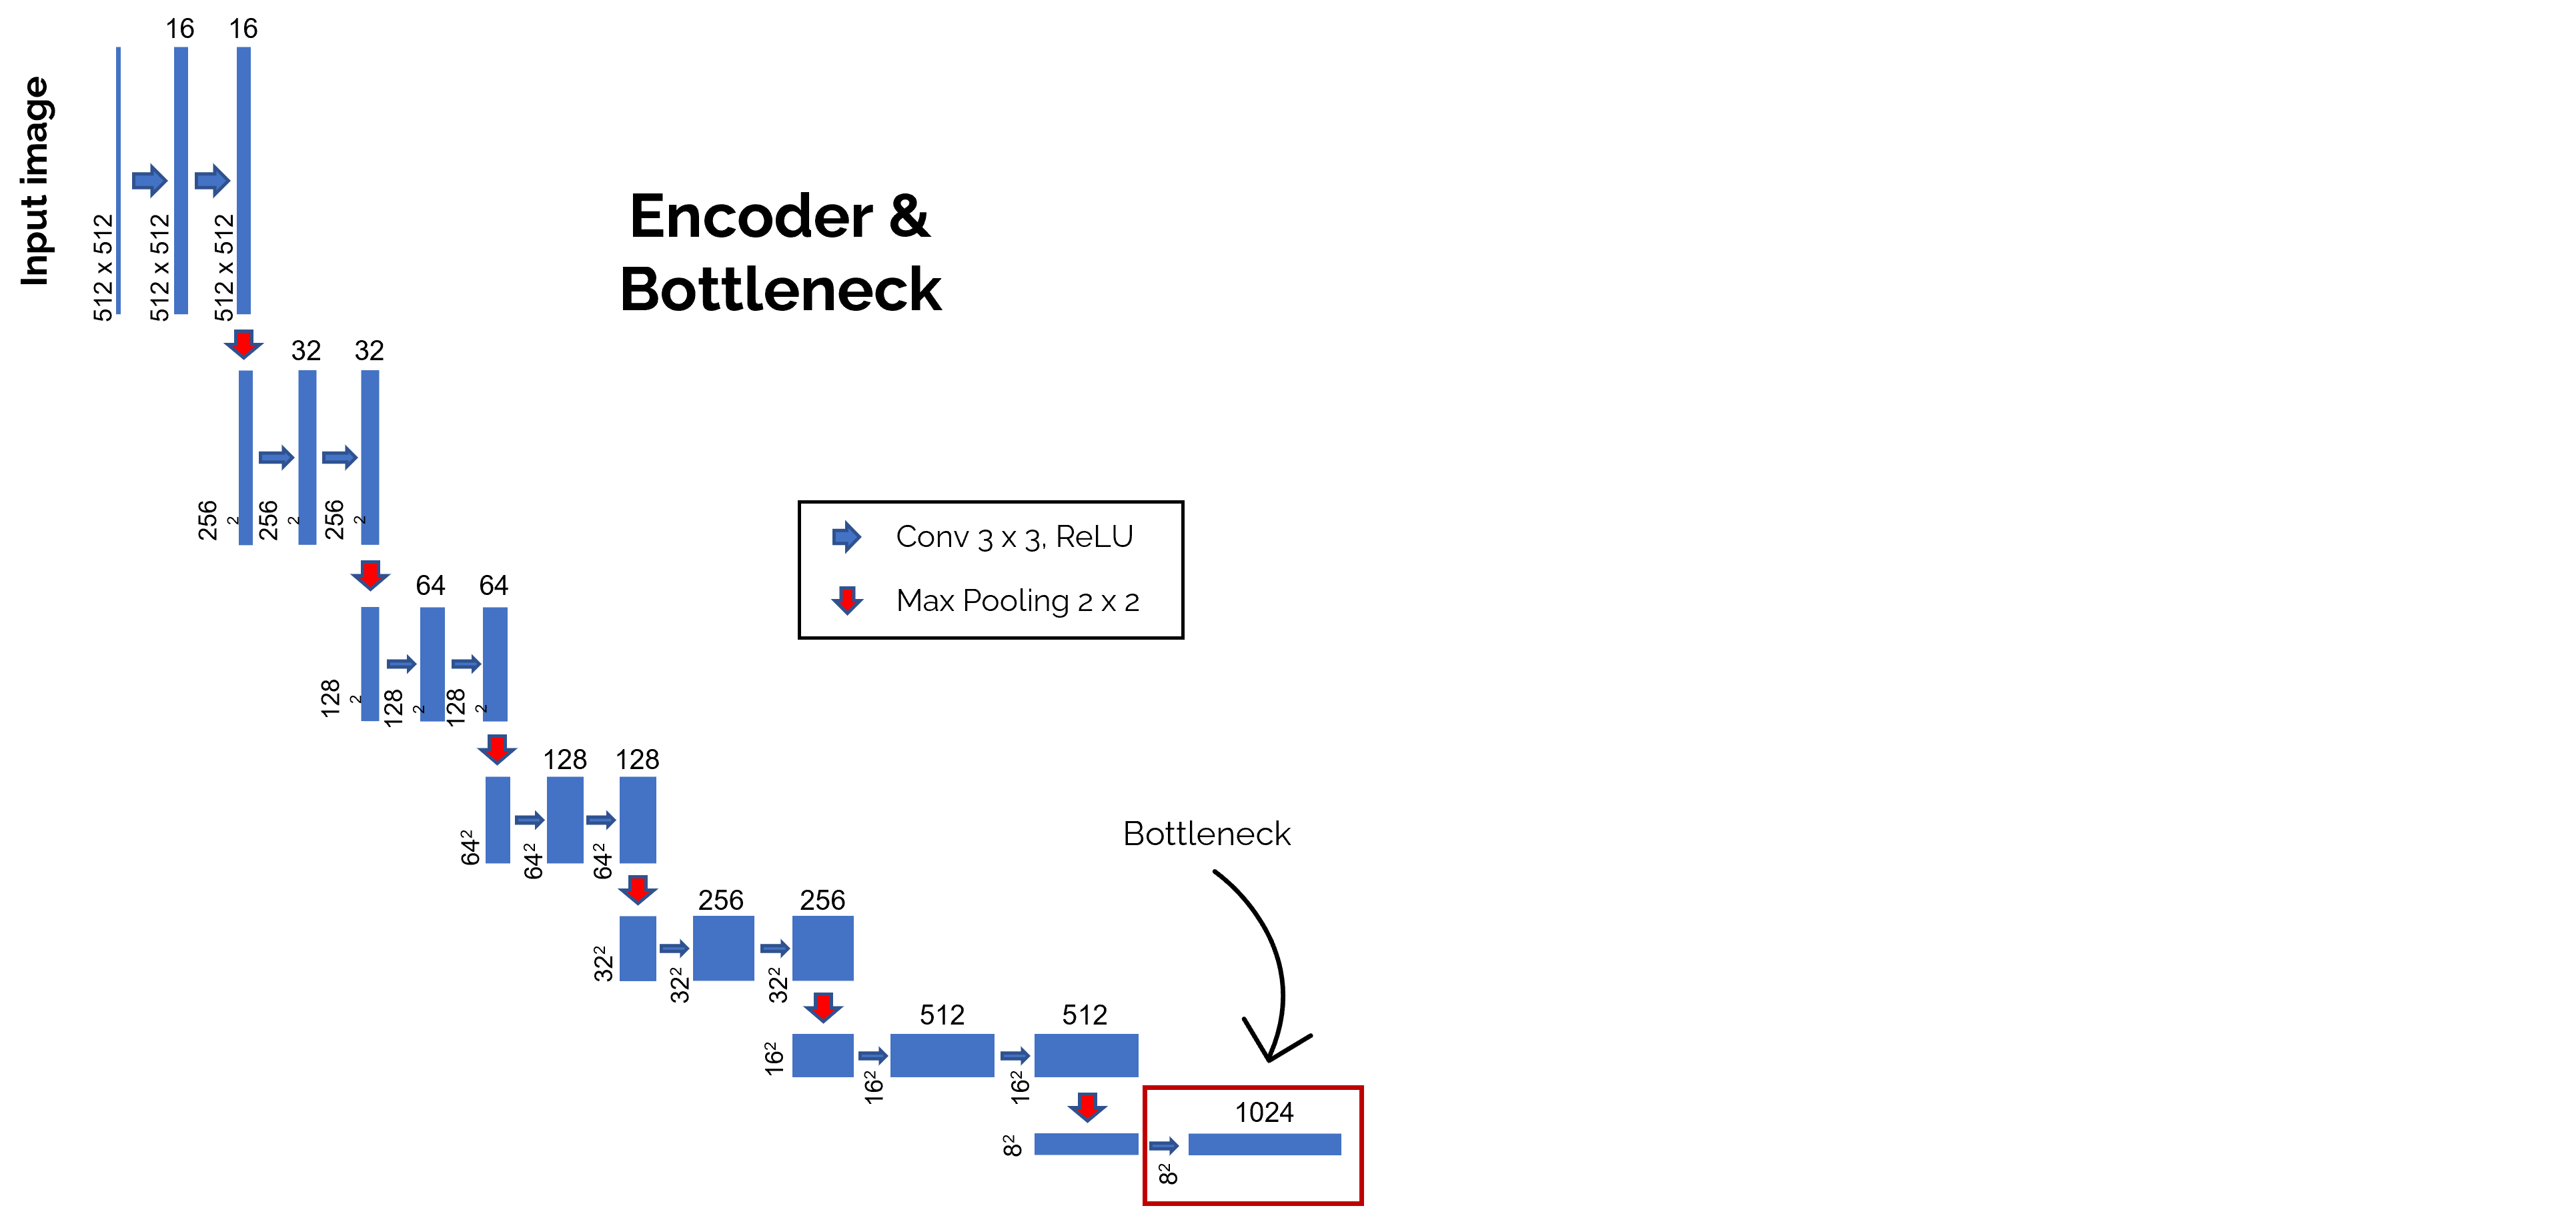

In [14]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block

    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns:
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    # Add two convolutional layers with a number of filter equal to n_filters, kernel size of 3, ReLU non-linear activation and "he_normal" as kernel initializer.
    # The padding and stride should be such that the output tensor size is equal to the size of the input tensor.
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv)

    # if dropout_prob > 0, add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
      conv = Dropout(dropout_prob)(conv)
    # if max_pooling is True, add a MaxPooling2D with 2x2 pool_size. Else, 'next_layer' will be the same as 'conv'.
    if max_pooling:
      next_layer = MaxPooling2D(pool_size = (2,2), strides=2)(conv)
    else:
      next_layer = conv
    # Save 'conv' in a variable called 'skip_connection', so that 'conv' is passed to the corresponding decoding step through a skip connection.
    skip_connection = conv

    return next_layer, skip_connection

Check if the code above works by running the following cell. It should print each of the layers of the encoder without errors.

In [15]:
input_size=(img_h, img_w, img_c)
n_filters = 32
inputs = Input(input_size)
cblock1 = conv_block(inputs, n_filters * 1)
model = tf.keras.Model(inputs=inputs, outputs=cblock1)

#Print model's layers
for layer in model.layers:
    print(layer.name)

input_1
conv2d
conv2d_1
max_pooling2d


### Build the Decoder (Upsampling Block)

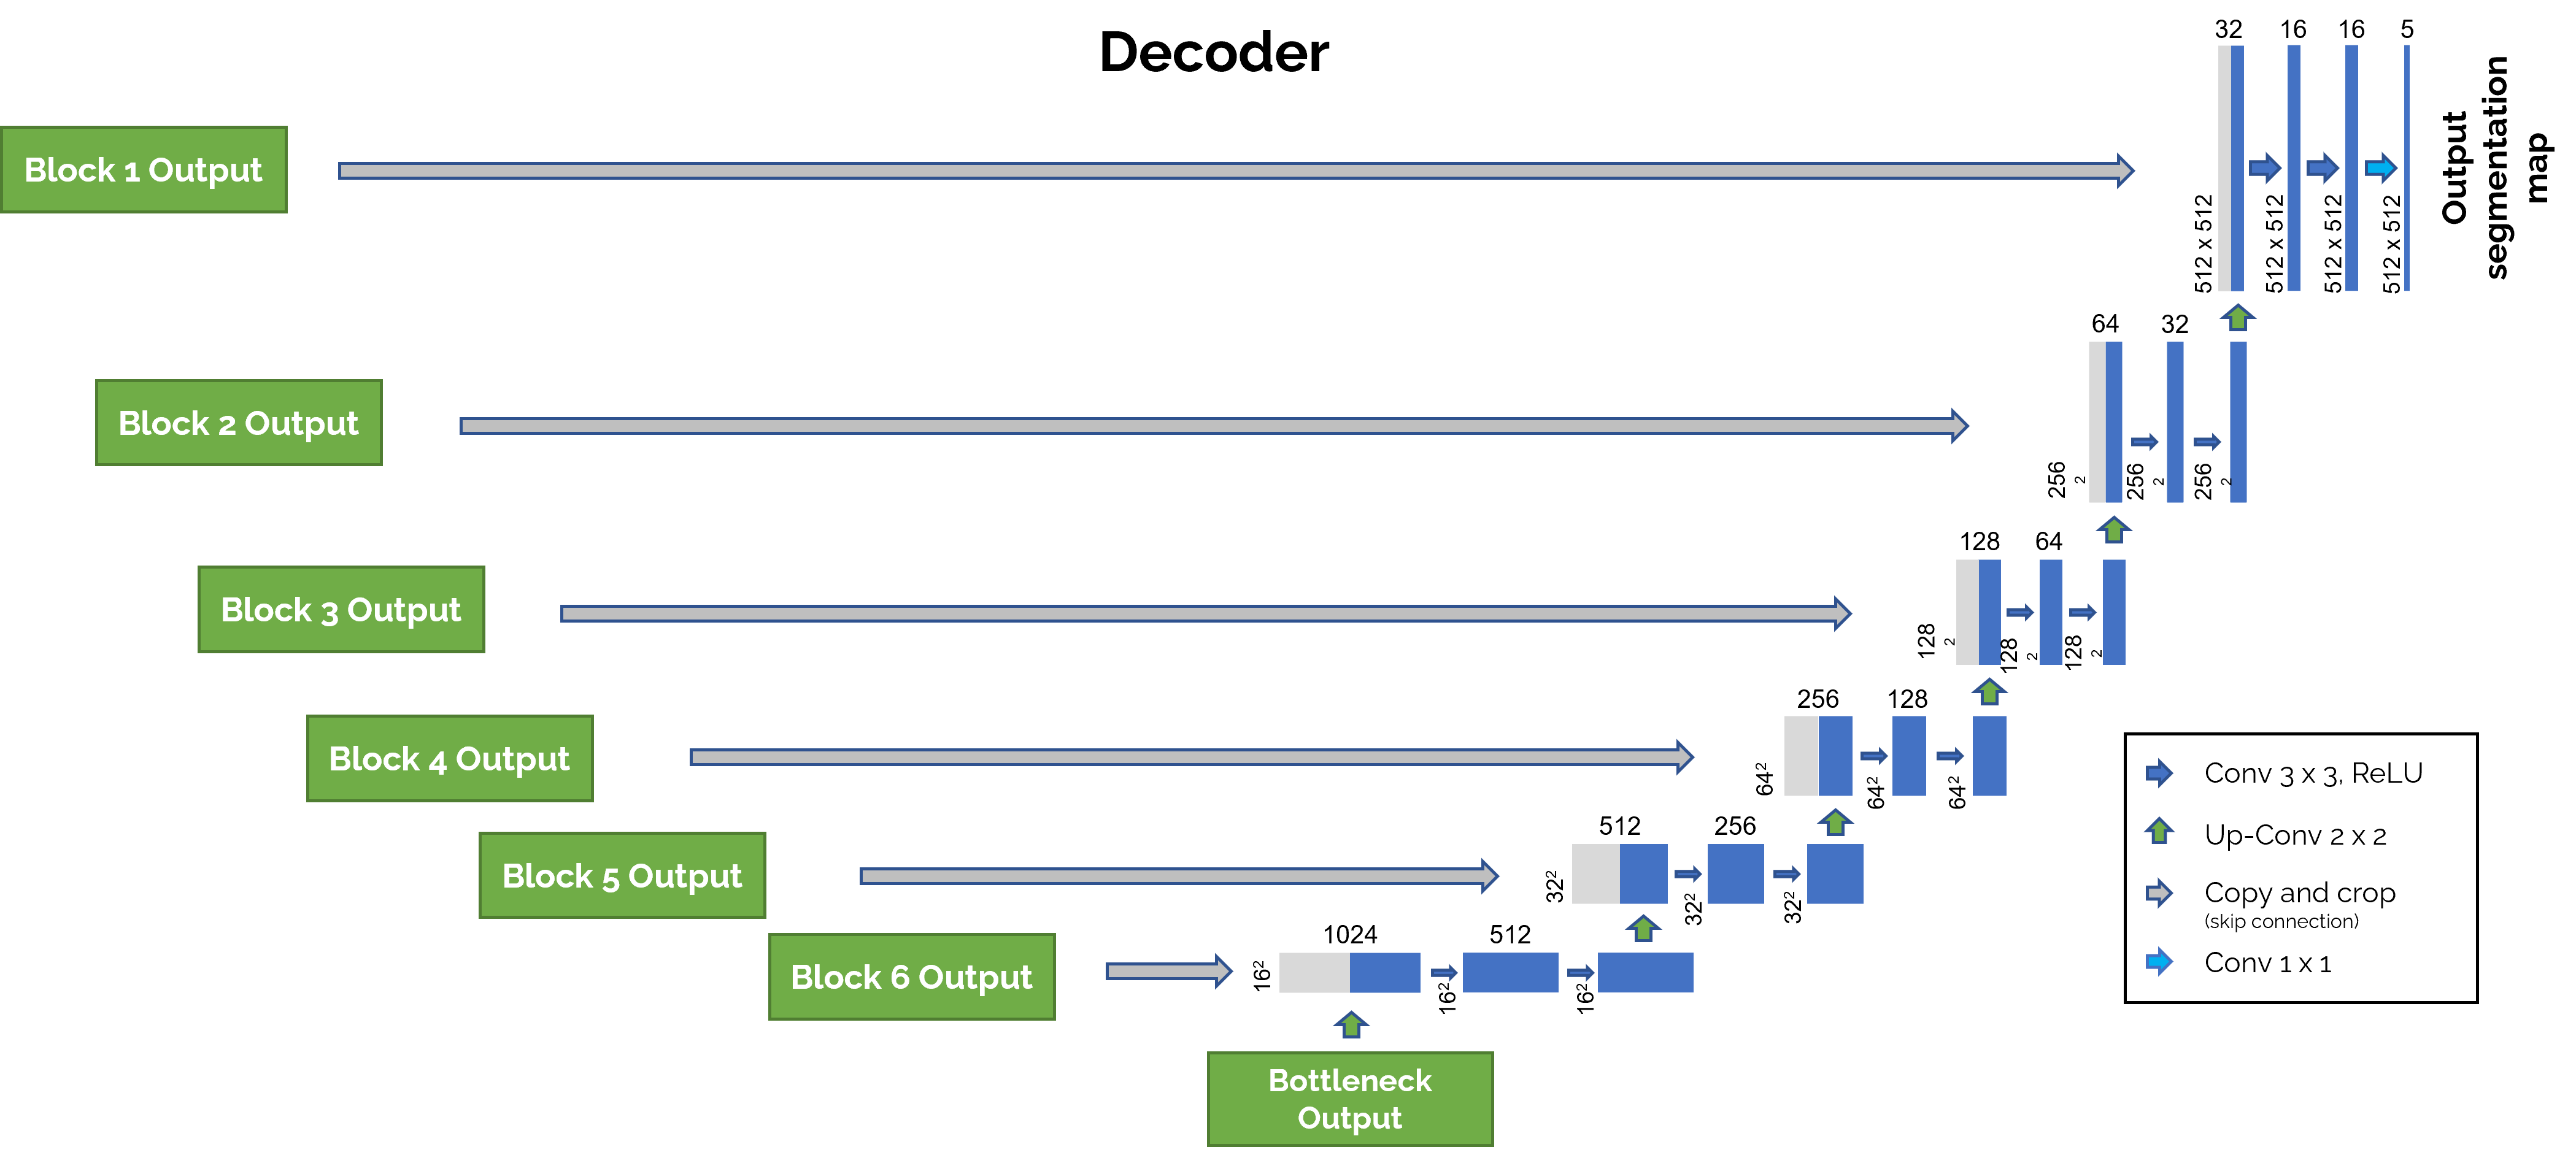

In [16]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block

    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns:
        conv -- Tensor output
    """

    # Implement a Conv2DTranspose layer that will take `n_filters` with
    # kernel shape (3,3) and a stride of (2,2). The padding shold be set in a way such
    # that the output has the same height/width dimension as the input.

    upsamp = Conv2DTranspose(n_filters, (3, 3), strides=(2, 2), padding='same')(expansive_input)

    # Implement a concatenate layer that merges the output of the previous
    # upsampling step with the output of the corresponding encoder block
    # passed through a skip connection. Both tensors should be concatenated
    # through the third axis (axis=3).

    merge = concatenate([upsamp, contractive_input], axis=3)

    # Implement two Conv2D layers with the same parameters as those
    # implemented in the downsampling block.

    conv = Conv2D(n_filters, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)

    return conv

Check if the code above works by running the following cell. It should print each of the layers of the decoder without errors.

In [17]:
input_size1 = (64, 64, 32)
input_size2 = (128, 128, 32)
n_filters = 32
expansive_inputs = Input(input_size1)
contractive_inputs =  Input(input_size2)
cblock1 = upsampling_block(expansive_inputs, contractive_inputs, n_filters * 1)
model1 = tf.keras.Model(inputs=[expansive_inputs, contractive_inputs], outputs=cblock1)

for layer in model1.layers:
    print(layer.name)

input_2
conv2d_transpose
input_3
concatenate
conv2d_2
conv2d_3


### Build the Model

In this part, everything is put together, by chaining the **encoder**, **bottleneck** (conv block without pooling), and **decoder**! The number of output classes is set to 5. That's because we are predicting 5 different labelmaps, 1 for each class present in this chest X-ray dataset (left lung, right lung, heart, left clavicle, right clavicle).

In [18]:
def unet_model(input_size=(256, 256, 1), n_filters=32, n_classes=1):
    """
    Unet model

    Arguments:
        input_size -- Input shape
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns:
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    # FIRST HALF: Contracting Path (encoding)
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters*8)
    cblock5 = conv_block(cblock4[0], n_filters*16)
    cblock6 = conv_block(cblock5[0], n_filters*32, dropout_prob=0.3)
    LSblock = conv_block(cblock6[0], n_filters*64, dropout_prob=0.3, max_pooling=False)

    # SECOND HALF: Expanding Path (decoding)
    ublock6 = upsampling_block(LSblock[0], cblock6[1], n_filters*32)
    ublock5 = upsampling_block(ublock6, cblock5[1], n_filters*16)
    ublock4 = upsampling_block(ublock5, cblock4[1], n_filters*8)
    ublock3 = upsampling_block(ublock4, cblock3[1], n_filters*4)
    ublock2 = upsampling_block(ublock3, cblock2[1], n_filters*2)
    ublock1 = upsampling_block(ublock2, cblock1[1], n_filters)

    conv_final = Conv2D(n_classes, (1, 1), padding='same', activation = 'softmax')(ublock1)

    model = tf.keras.Model(inputs=inputs, outputs=conv_final)

    return model

### Initialize model and summary

In [19]:
# Input size: (img_h, img_w, img_c); Number of filters: 16. Number of output classes: equal to mask_c (# classes)
unet = unet_model(input_size = (img_h, img_w, img_c), n_filters = 16, n_classes = mask_c)  

In [20]:
# Model summary
unet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 512, 512, 16  160         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_5 (Conv2D)              (None, 512, 512, 16  2320        ['conv2d_4[0][0]']               
                                )                                                           

### Loss Function

In semantic segmentation, you need as many masks as object classes you have. In the dataset we are using, each pixel in every mask has been assigned a probability that it belongs to a certain class, from 0 to 1 (binary). For every output mask, those pixels that have a probability higher than 0.5 (threshold), will have a pixel contributing to the segmentation.

In [21]:
# Dice coefficient
def dice_coef(y_true, y_pred, smooth=100):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

In [22]:
# Define Adam optimizer. 
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
# Define BinaryCrossEntropyLoss. 
loss = tf.keras.losses.BinaryCrossentropy()
# Compile the model. Use 'accuracy' and dice_coef (without quotes), i.e., ['accuracy',dice_coef], as metrics.
unet.compile(optimizer=opt,
             loss=loss,
             metrics=['accuracy',dice_coef]) 

## Train the Model

In this section, we are going to train (fit) the model. In this process, the weights and other parameters of the model will be updated iteratively. Typically, the larger and more diverse the data, the better the performance and, therefore, the generalization of our model to new data.

Consequently, we are going to fit our model considering the following:
* Train for 200 epochs.
* Use a batch size of 16 images.
* 25% of the training data used for validation.
* Use a callback which incorporates Early Stopping in the training procedure. This Early Stopping is going to use `val_dice_coef` (mode='max') metric to decide whether to early stop or not. Early Stopping patience of 10, verbose option activated and restore the best weights (`restore_best_weights=True`).

In [23]:
epochs =  200 
batch_size = 16 
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_dice_coef', patience = 10, mode = 'max', verbose = 1, restore_best_weights=True) 
cb = [es]  #Include the callbacks in an array, separated with commas. If only one callback, commas not needed.

In [24]:
model_history = unet.fit(X_train, y_train, batch_size, epochs, callbacks = cb, validation_split = 0.25)  

Epoch 1/200
10/10 [==============================] - 136s 13s/step - loss: 1.4818 - accuracy: 0.4392 - dice_coef: 0.1478 - val_loss: 0.4742 - val_accuracy: 0.6602 - val_dice_coef: 0.1554
Epoch 2/200
10/10 [==============================] - 128s 13s/step - loss: 0.4367 - accuracy: 0.6039 - dice_coef: 0.1519 - val_loss: 0.3742 - val_accuracy: 0.5694 - val_dice_coef: 0.1720
Epoch 3/200
10/10 [==============================] - 129s 13s/step - loss: 0.3357 - accuracy: 0.5636 - dice_coef: 0.1707 - val_loss: 0.3123 - val_accuracy: 0.5176 - val_dice_coef: 0.1853
Epoch 4/200
10/10 [==============================] - 130s 13s/step - loss: 0.2850 - accuracy: 0.5146 - dice_coef: 0.1812 - val_loss: 0.2622 - val_accuracy: 0.4889 - val_dice_coef: 0.2103
Epoch 5/200
10/10 [==============================] - 126s 13s/step - loss: 0.2656 - accuracy: 0.4117 - dice_coef: 0.2027 - val_loss: 0.2580 - val_accuracy: 0.4152 - val_dice_coef: 0.2290
Epoch 6/200
10/10 [==============================] - 125s 13s/ste

### Plot Model Accuracy
Plot the learning curves of our model during the training and validation.

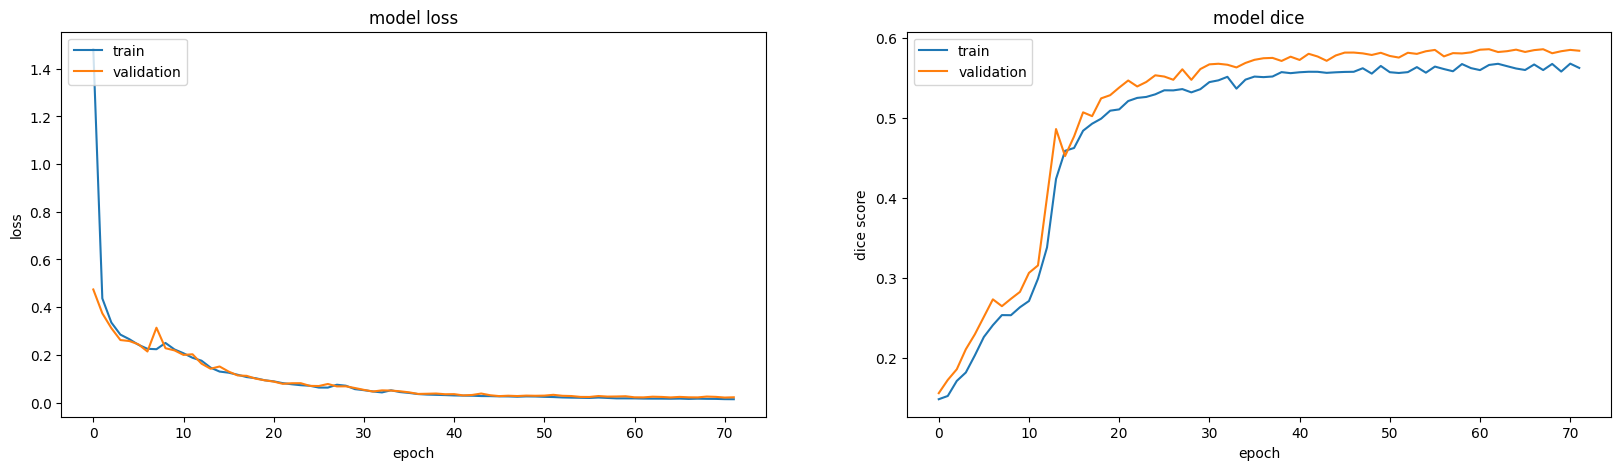

In [25]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# summarize history for loss
plt.subplot(1,2,2)
plt.plot(model_history.history['dice_coef'])
plt.plot(model_history.history['val_dice_coef'])
plt.title('model dice')
plt.ylabel('dice score')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

## Test the Model

Now, let's test the model on the independent test set (`X_test`). First, we are going to predict the outputs given the inputs (`X_test`). Later on, we will assign 1 to the probabilities greater than 0.5 (threshold). Else, they will be 0 (background).


In [26]:
y_test_pred =  unet.predict(X_test)
print(y_test_pred.shape)

2/2 [==============================] - 10s 3s/step
(50, 512, 512, 5)


In [27]:
y_test_pred = np.where(y_test_pred > 0.5, 1.0, 0.0)

### Visualize some testing examples

Let's visualize some testing examples and compare GT vs predicted segmentations.

In [28]:
def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice coefficient for comparing the similarity of two sets.
    """
    y_true_f = K.flatten(K.cast(y_true, 'float32')) # Cast y_true to float32
    y_pred_f = K.flatten(K.cast(y_pred, 'float32')) # Cast y_pred to float32
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

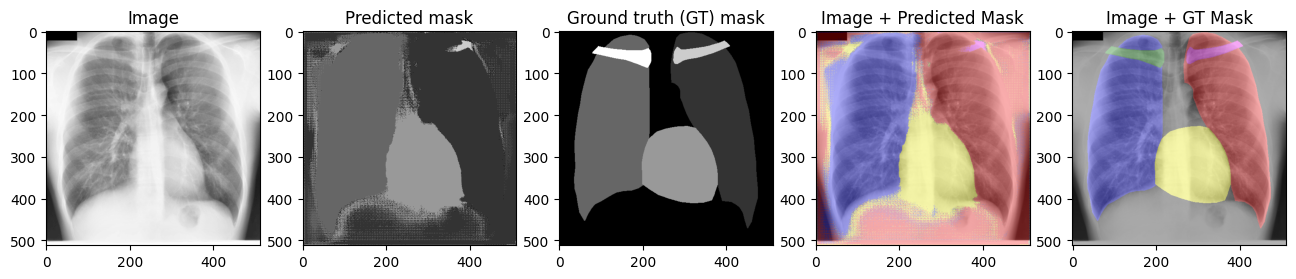

Dice score: 0.6858938932418823


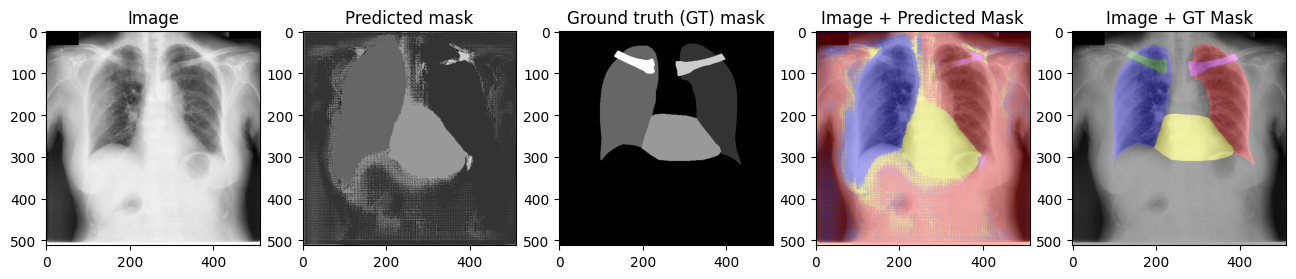

Dice score: 0.4065179228782654


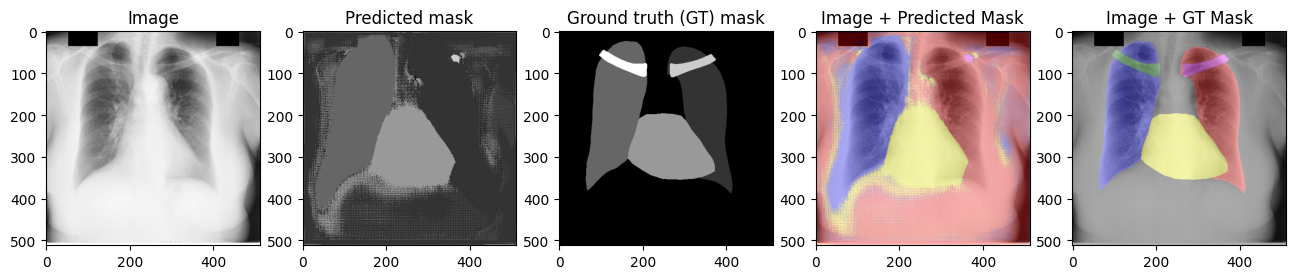

Dice score: 0.4849855303764343


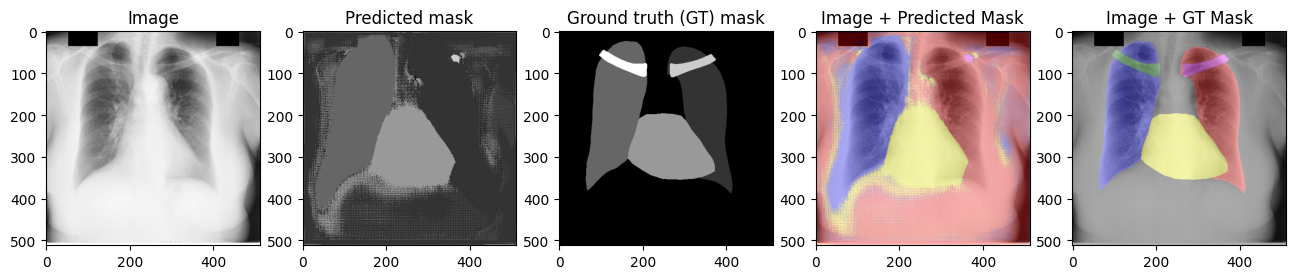

Dice score: 0.4849855303764343


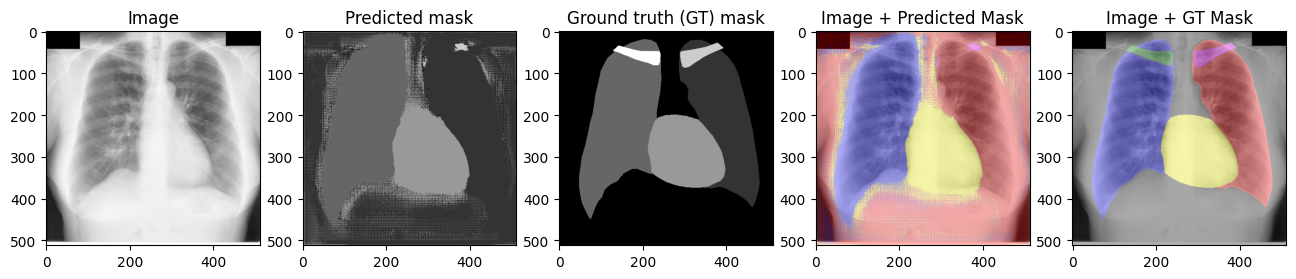

Dice score: 0.6111786961555481


In [29]:
# Display some examples of predicted mask
indx = np.random.randint(0, len(X_test), 5)

for i in indx:
  plot_image_and_pred_label(X_test[i], y_test_pred[i], y_test[i], values_255=False)
  plt.show()
  print(f"Dice score: {dice_coef(y_test[i], y_test_pred[i])}")

### Test metrics

Finally, let's compute the performance of our model on the whole independent test set. We will use Dice score to assess how good our model performs on these unseen data.

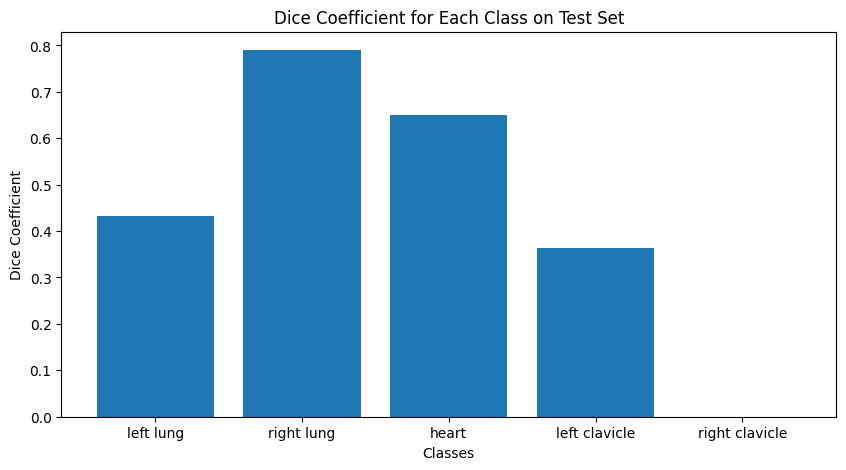

In [31]:
dice_coef(y_test, y_test_pred)  

# Calculate Dice coefficient for each class
dice_scores = [dice_coef(y_test[..., i], y_test_pred[..., i]) for i in range(mask_c)]

# Plot Dice coefficient for each class
plt.figure(figsize=(10, 5))
plt.bar(titles, dice_scores)
plt.xlabel('Classes')
plt.ylabel('Dice Coefficient')
plt.title('Dice Coefficient for Each Class on Test Set')
plt.show()